# Converting each MOF to a graph
* reads in each MOF from DDEC charge-assigned dataset
* infers bonds using distance-based criterion
* writes to file: 
    * list of crystal names: `list_of_crystals.txt`
    * node features: `graphs/xtalname_node_features.npy`
    * edge list and features: `graphs/xtalname.edge_info`. the edges are 0-based indexed.
    * node labels (charges) `graphs/xtalname_node_labels.npy`

In [18]:
using PorousMaterials # use major_refactor branch.
using DataFrames
using PyPlot
using NPZ
using CSV
using LightGraphs
using LinearAlgebra
using Logging
using Printf
using DelimitedFiles
using ProgressMeter
using PyCall
push!(LOAD_PATH, pwd()) # to see Bonds.jl
using Bonds

# global_logger(Logging.SimpleLogger(stdout, Logging.Info)) # to print @debug put Logging.Debug
global_logger(Logging.SimpleLogger(stdout, Logging.Debug)) # to print @debug put Logging.Debug

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(Base.Libc.WindowsRawSocket(0x0000000000000394) open, 0 bytes waiting))), Debug, Dict{Any,Int64}())

### get list of MOFs
MOF `.cif` files with DDEC-assigned charges are found in `xtals/`. These were downloaded from [here](https://github.com/gregchung/gregchung.github.io/blob/master/CoRE-MOFs/core-mof-1.0-ddec.tar). The paper corresponding to these structures is [here](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.5b03836).

In [2]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "xtals")

"C:\\Users\\Arni\\Documents\\GitHub\\mpn_charges\\build_graphs\\xtals"

In [3]:
xtalnames = map(x -> replace(x, ".cif" => ""), readdir("xtals"))

2932-element Array{String,1}:
 "ABAVIJ_clean"  
 "ABAVOP_clean"  
 "ABEXIQ_clean"  
 "ABEXOW_clean"  
 "ABEXUC_clean"  
 "ABEYAJ_clean"  
 "ABEYIR"        
 "ABIYIV"        
 "ABUWOJ_clean"  
 "ACAKUM"        
 "ACALIB_clean"  
 "ACODED"        
 "ACOLIP_clean"  
 ⋮               
 "ZILBAZ_clean"  
 "ZILBED_clean"  
 "ZIMJOW_clean"  
 "ZISYAD_clean"  
 "Zn-DOBDC"      
 "ZnBDC"         
 "ZnBDCdabco"    
 "ZNGLUD01_clean"
 "ZNGLUD_clean"  
 "ZnHBDC"        
 "ZnMOF-74"      
 "ZURQOS_clean"  

### find unique atomic species

In [4]:
unique_atomic_species = Set{Symbol}()

for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif")
    for a in unique(crystal.atoms.species)
        push!(unique_atomic_species, a)
    end
end
unique_atomic_species

println("# unique atomic species: ", length(unique_atomic_species))

# unique atomic species: 74


### analyze occurance of atomic species in MOFs
i.e., how many MOFs contain atom $i$? this is important to ensure we can adequately learn charges on rare MOF atoms.

In [5]:
species_occurance = Dict{Symbol, Int}(a => 0 for a in unique_atomic_species)
for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif")
    for a in unique(crystal.atoms.species)
        species_occurance[a] += 1
    end
end
species_occurance

Dict{Symbol,Int64} with 74 entries:
  :Cl => 116
  :Al => 33
  :Re => 8
  :Be => 2
  :Cr => 20
  :Na => 39
  :Sb => 2
  :Ni => 121
  :S  => 221
  :Ru => 10
  :Tm => 19
  :W  => 16
  :Nd => 91
  :O  => 2591
  :Th => 4
  :F  => 83
  :Co => 285
  :Gd => 75
  :Rh => 2
  :Pu => 1
  :Ca => 44
  :N  => 1765
  :Yb => 27
  :As => 2
  :Se => 2
  ⋮   => ⋮

put in a `DataFrame` for sorting and plotting

In [6]:
df_species_occurance = DataFrame(atom=collect(keys(species_occurance)), 
                                 nb_mofs=collect(values(species_occurance))
                                 )
sort!(df_species_occurance, :nb_mofs)
first(df_species_occurance, 6)

,atom,nb_mofs
,Symbol,Int64
1,Pu,1
2,Ir,1
3,Be,2
4,Sb,2
5,Rh,2
6,As,2


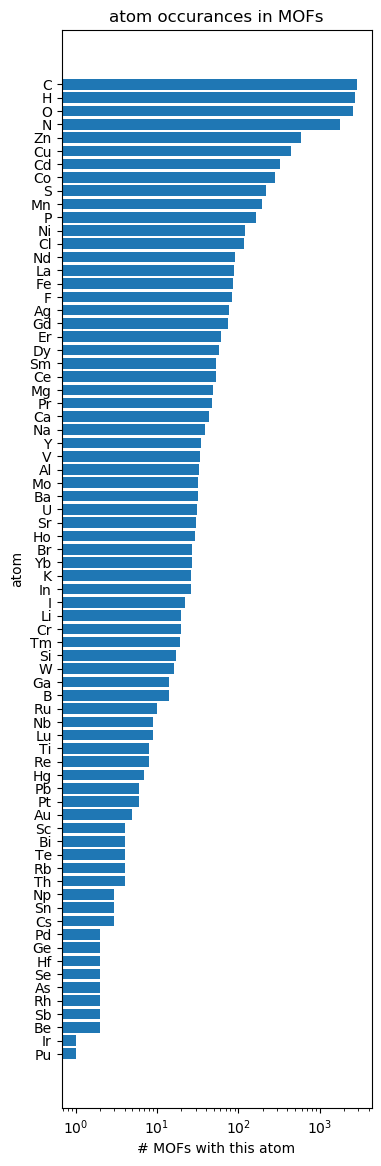

PyObject Text(0.5, 1, 'atom occurances in MOFs')

In [7]:
figure(figsize=(4, 14))
barh(1:nrow(df_species_occurance), df_species_occurance[:, :nb_mofs])
yticks(1:nrow(df_species_occurance), df_species_occurance[:, :atom])
xlabel("# MOFs with this atom")
ylabel("atom")
xscale("log")
title("atom occurances in MOFs")

### atom <--> integer mapping for one-hot encoding

sort my occurance

In [8]:
sort!(df_species_occurance, :nb_mofs, rev=true)
const ATOMS = deepcopy(df_species_occurance[:, :atom])
ATOMS

74-element Array{Symbol,1}:
 :C 
 :H 
 :O 
 :N 
 :Zn
 :Cu
 :Cd
 :Co
 :S 
 :Mn
 :P 
 :Ni
 :Cl
 ⋮  
 :Sn
 :Np
 :Be
 :Sb
 :Rh
 :As
 :Se
 :Hf
 :Ge
 :Pd
 :Pu
 :Ir

In [9]:
const ATOM_TO_INT = Dict{Symbol, Int}(a => i for (i, a) in enumerate(ATOMS))
ATOM_TO_INT

Dict{Symbol,Int64} with 74 entries:
  :Cl => 13
  :Al => 30
  :Re => 51
  :Be => 65
  :Cr => 41
  :Na => 27
  :Sb => 66
  :Ni => 12
  :S  => 9
  :Ru => 48
  :Tm => 43
  :W  => 45
  :Nd => 14
  :O  => 3
  :Th => 57
  :F  => 17
  :Co => 8
  :Gd => 19
  :Rh => 67
  :Pu => 73
  :Ca => 26
  :N  => 4
  :Yb => 36
  :As => 68
  :Se => 69
  ⋮   => ⋮

### write graph structure, edge features, node features, and node labels to file for each MOF

In [10]:
isdir("graphs") ? nothing : mkdir("graphs")

In [11]:
@info "making edge list zero-based indexed for Python"

keep_xtal = [true for i = 1:length(xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("graphs", xtalname * "_node_features.npy"), x_ν)

    ###
    #    node labels (the charges)
    ###
    y_ν = deepcopy(crystal.charges.q)
    npzwrite(joinpath("graphs", xtalname * "_node_labels.npy"), y_ν)
    @assert length(y_ν) == size(x_ν)[1]

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("graphs", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end

writedlm(open("list_of_crystals.txt", "w"), xtalnames[keep_xtal])

┌ Info: making edge list zero-based indexed for Python
└ @ Main In[11]:1


Progress:   1%|█                                        |  ETA: 0:53:10

┌ Warning: atom 197 = Cl in ADOBAX.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 198 = Cl in ADOBAX.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158


Progress:   1%|█                                        |  ETA: 0:54:55

┌ Warning: throwing out 
│   crystal.name = ADOBAX.cif
└ @ Main In[11]:23


Progress:   1%|█                                        |  ETA: 0:56:45

┌ Warning: atom 197 = Cl in ADOBOL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 198 = Cl in ADOBOL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ADOBOL_clean.cif
└ @ Main In[11]:23


Progress:   3%|██                                       |  ETA: 0:43:30

┌ Warning: hydrogen atom 10 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 28 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 37 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ASALIP_clean.cif
└ @ Main In[11]:23


Progress:   6%|███                                      |  ETA: 0:50:16

┌ Warning: hydrogen atom 10 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 11 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 17 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 18 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 25 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZ

Progress:   6%|███                                      |  ETA: 0:50:57

┌ Warning: atom 7 = Zn in BICDAU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 9 = Zn in BICDAU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = BICDAU_clean.cif
└ @ Main In[11]:23


Progress:   7%|███                                      |  ETA: 0:50:24

┌ Warning: hydrogen atom 10 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 38 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 52 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BONWIL_clean.cif
└ @ Main In[11]:23


Progress:   7%|███                                      |  ETA: 0:50:47

┌ Warning: hydrogen atom 31 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 64 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 97 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 130 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BORBEQ_clean.cif
└ @ Main In[11]:23


Progress:   8%|████                                     |  ETA: 0:48:18

┌ Warning: atom 17 = Cu in CAYBAH01.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 18 = Cu in CAYBAH01.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 19 = Cu in CAYBAH01.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 20 = Cu in CAYBAH01.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 21 = Cu in CAYBAH01.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 22 = Cu in CAYBAH01.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 23 = Cu in C

Progress:  11%|█████                                    |  ETA: 0:43:55

Voronoi problems with COF-5.cif

Progress:  11%|█████                                    |  ETA: 0:43:47

Progress:  17%|████████                                 |  ETA: 0:41:18

Voronoi problems with DUXZIG01_clean.cif
┌ Warning: atom 1 = Zn in DUXZIG01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in DUXZIG01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = DUXZIG01_clean.cif
└ @ Main In[11]:23


Progress:  22%|██████████                               |  ETA: 0:37:30

┌ Warning: hydrogen atom 14 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 16 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 26 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FAZZEM_clean.cif
└ @ Main In[11]:23


Progress:  24%|██████████                               |  ETA: 0:36:44

┌ Warning: hydrogen atom 9 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 10 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 16 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 17 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 23 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT

Progress:  25%|███████████                              |  ETA: 0:36:22

Voronoi problems with FUNBOG_clean.cif
┌ Warning: atom 1 = Zn in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 71 = Br in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 72 = Br in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FUNBOG_clean.cif
└ @ Main In[11]:23


Progress:  25%|███████████                              |  ETA: 0:36:19

Voronoi problems with FUNCEX_clean.cif
┌ Warning: atom 1 = Zn in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 73 = Br in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 74 = Br in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FUNCEX_clean.cif
└ @ Main In[11]:23
┌ Warning: atom 127 = Cl in FUSWIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158


Progress:  25%|███████████                              |  ETA: 0:36:18

┌ Warning: atom 128 = Cl in FUSWIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 129 = Cl in FUSWIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 130 = Cl in FUSWIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FUSWIA_clean.cif
└ @ Main In[11]:23


Progress:  28%|████████████                             |  ETA: 0:35:51

┌ Warning: atom 131 = O in GESFAN_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 132 = O in GESFAN_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = GESFAN_clean.cif
└ @ Main In[11]:23


Progress:  28%|████████████                             |  ETA: 0:35:42

┌ Warning: atom 1 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 5 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 6 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning:

Progress:  31%|█████████████                            |  ETA: 0:33:29

Voronoi problems with HAFTOZ_clean.cif
┌ Warning: atom 1 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 5 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 6 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMate

Progress:  33%|██████████████                           |  ETA: 0:32:39

┌ Warning: hydrogen atom 17 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 18 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 20 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 29 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 30 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 32 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZ

Progress:  33%|██████████████                           |  ETA: 0:32:21

┌ Warning: atom 7 = Zn in HIGRIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 8 = Zn in HIGRIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = HIGRIA_clean.cif
└ @ Main In[11]:23


Progress:  33%|██████████████                           |  ETA: 0:32:19

┌ Warning: carbon atom 89 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 90 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 91 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 92 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 93 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 94 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 95 in HITXUE.cif is bonded to

Progress:  35%|███████████████                          |  ETA: 0:31:33

┌ Warning: atom 7 = Zn in IBOTAU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IBOTAU_clean.cif
└ @ Main In[11]:23


Progress:  35%|███████████████                          |  ETA: 0:31:19

┌ Warning: atom 43 = Cl in ICORAV_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 44 = Cl in ICORAV_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ICORAV_clean.cif
└ @ Main In[11]:23


Progress:  36%|███████████████                          |  ETA: 0:30:56

┌ Warning: atom 193 = Cl in IGAHAB_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 194 = Cl in IGAHAB_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IGAHAB_clean.cif
└ @ Main In[11]:23


Progress:  36%|███████████████                          |  ETA: 0:30:47

┌ Warning: atom 9 = Zn in IGOCOX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 10 = Zn in IGOCOX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IGOCOX_clean.cif
└ @ Main In[11]:23


Progress:  38%|████████████████                         |  ETA: 0:29:43

┌ Warning: atom 1 = Bi in IRISAD01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Bi in IRISAD01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IRISAD01_clean.cif
└ @ Main In[11]:23


Progress:  38%|████████████████                         |  ETA: 0:29:36

┌ Warning: hydrogen atom 8 in ISEQIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 18 in ISEQIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ISEQIH_clean.cif
└ @ Main In[11]:23


Progress:  39%|████████████████                         |  ETA: 0:29:31

┌ Warning: atom 9 = Cu in IVEGEV_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 10 = Cu in IVEGEV_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IVEGEV_clean.cif
└ @ Main In[11]:23


Progress:  39%|█████████████████                        |  ETA: 0:29:06

Voronoi problems with IYIHUU_clean.cif
┌ Warning: atom 1 = Zn in IYIHUU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in IYIHUU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: hydrogen atom 27 in IYIHUU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 28 in IYIHUU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: atom 79 = Br in IYIHUU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 80 = Br in IYIHUU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\package

Progress:  40%|█████████████████                        |  ETA: 0:28:40

┌ Warning: atom 23 = H in JEMQEY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 44 = H in JEMQEY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = JEMQEY_clean.cif
└ @ Main In[11]:23


Progress:  42%|██████████████████                       |  ETA: 0:27:51

Voronoi problems with KECRAL10_clean.cif
┌ Warning: atom 1 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = KECRAL10_clean.cif
└ @ Main In[11]:23


Progress:  44%|███████████████████                      |  ETA: 0:27:13

┌ Warning: carbon atom 102 in KOJZAL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 106 in KOJZAL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 138 in KOJZAL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 142 in KOJZAL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = KOJZAL_clean.cif
└ @ Main In[11]:23


Progress:  47%|████████████████████                     |  ETA: 0:25:32

┌ Warning: hydrogen atom 7 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 11 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 15 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = LETRIN_clean.cif
└ @ Main In[11]:23


Progress:  47%|████████████████████                     |  ETA: 0:25:31

┌ Warning: hydrogen atom 7 in LETROT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 11 in LETROT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 15 in LETROT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in LETROT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = LETROT_clean.cif
└ @ Main In[11]:23


Progress:  48%|████████████████████                     |  ETA: 0:25:10

┌ Warning: carbon atom 23 in LIQGEY_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 26 in LIQGEY_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 27 in LIQGEY_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 30 in LIQGEY_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = LIQGEY_clean.cif
└ @ Main In[11]:23


Progress:  51%|█████████████████████                    |  ETA: 0:23:33

┌ Warning: atom 2 = Ag in MAYPIM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Ag in MAYPIM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 6 = Ag in MAYPIM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 8 = Ag in MAYPIM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = MAYPIM_clean.cif
└ @ Main In[11]:23


Progress:  54%|███████████████████████                  |  ETA: 0:21:57

┌ Warning: atom 17 = Pb in MOF-70.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 18 = Pb in MOF-70.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 19 = Pb in MOF-70.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 20 = Pb in MOF-70.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = MOF-70.cif
└ @ Main In[11]:23


Progress:  54%|███████████████████████                  |  ETA: 0:21:55

┌ Warning: carbon atom 79 in MOGYAI_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 81 in MOGYAI_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 83 in MOGYAI_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 85 in MOGYAI_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = MOGYAI_clean.cif
└ @ Main In[11]:23


Progress:  55%|███████████████████████                  |  ETA: 0:21:12

┌ Warning: atom 81 = O in NAJGAH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 90 = O in NAJGAH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NAJGAH_clean.cif
└ @ Main In[11]:23


Progress:  56%|███████████████████████                  |  ETA: 0:20:59

┌ Warning: carbon atom 109 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 110 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 134 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 135 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 159 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 160 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning:

Progress:  56%|███████████████████████                  |  ETA: 0:20:58

┌ Warning: hydrogen atom 14 in NAXLEF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = NAXLEF_clean.cif
└ @ Main In[11]:23


Progress:  57%|████████████████████████                 |  ETA: 0:20:26

┌ Warning: hydrogen atom 49 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 50 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 51 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 52 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = NEVGIE.cif
└ @ Main In[11]:23


Progress:  57%|████████████████████████                 |  ETA: 0:20:26

┌ Warning: atom 257 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 258 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 259 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 260 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 261 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 262 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 263 = Cl in NEVPUA

Progress:  57%|████████████████████████                 |  ETA: 0:20:14

┌ Warning: atom 74 = F in NICZAA01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 75 = F in NICZAA01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NICZAA01_clean.cif
└ @ Main In[11]:23


Progress:  60%|█████████████████████████                |  ETA: 0:18:45

Voronoi problems with OFAWEZ_clean.cif
┌ Warning: atom 1 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 5 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 6 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMate

Progress:  63%|██████████████████████████               |  ETA: 0:17:44

┌ Warning: hydrogen atom 9 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 14 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = OXAZIX_clean.cif
└ @ Main In[11]:23


Progress:  63%|██████████████████████████               |  ETA: 0:17:34

┌ Warning: hydrogen atom 5 in PAMGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 11 in PAMGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PAMGIV_clean.cif
└ @ Main In[11]:23


Progress:  63%|███████████████████████████              |  ETA: 0:17:33

┌ Warning: hydrogen atom 10 in PAMHES01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 16 in PAMHES01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PAMHES01_clean.cif
└ @ Main In[11]:23


Progress:  63%|███████████████████████████              |  ETA: 0:17:32

┌ Warning: hydrogen atom 5 in PAMHES_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 11 in PAMHES_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PAMHES_clean.cif
└ @ Main In[11]:23


Progress:  67%|████████████████████████████             |  ETA: 0:15:39

┌ Warning: hydrogen atom 14 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 15 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 25 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 34 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 35 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZ

Progress:  68%|████████████████████████████             |  ETA: 0:15:24

┌ Warning: hydrogen atom 20 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 36 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 52 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 68 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QARTEK_clean.cif
└ @ Main In[11]:23


Progress:  69%|█████████████████████████████            |  ETA: 0:14:40

┌ Warning: hydrogen atom 7 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 11 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 15 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QOPHEI_clean.cif
└ @ Main In[11]:23


Progress:  70%|█████████████████████████████            |  ETA: 0:14:13

Voronoi problems with QUQPOI_clean.cif
┌ Warning: atom 1 = Zn in QUQPOI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = QUQPOI_clean.cif
└ @ Main In[11]:23


Progress:  73%|██████████████████████████████           |  ETA: 0:12:58

┌ Warning: atom 285 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 286 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 287 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 288 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 305 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 306 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 307 = C in RIDKOE.cif is

Progress:  74%|███████████████████████████████          |  ETA: 0:12:27

┌ Warning: atom 35 = H in RUVMAX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 36 = H in RUVMAX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = RUVMAX_clean.cif
└ @ Main In[11]:23


Progress:  76%|████████████████████████████████         |  ETA: 0:11:12

┌ Warning: atom 1 = Cd in SOGWIV_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Cd in SOGWIV_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Cd in SOGWIV_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Cd in SOGWIV_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = SOGWIV_clean.cif
└ @ Main In[11]:23


Progress:  77%|████████████████████████████████         |  ETA: 0:10:56

┌ Warning: hydrogen atom 10 in SUHHOT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = SUHHOT_clean.cif
└ @ Main In[11]:23


Progress:  78%|█████████████████████████████████        |  ETA: 0:10:16

Voronoi problems with TEDGOA_clean.cif
┌ Warning: atom 1 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = TEDGOA_clean.cif
└ @ Main In[11]:23


Progress:  79%|█████████████████████████████████        |  ETA: 0:09:50

┌ Warning: hydrogen atom 17 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 30 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 43 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 56 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 69 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 82 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousM

Progress:  81%|██████████████████████████████████       |  ETA: 0:09:08

┌ Warning: hydrogen atom 35 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 36 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 37 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 38 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 39 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 40 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZ

Progress:  81%|██████████████████████████████████       |  ETA: 0:08:51

┌ Warning: hydrogen atom 16 in UJARAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 28 in UJARAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = UJARAZ_clean.cif
└ @ Main In[11]:23


Progress:  83%|███████████████████████████████████      |  ETA: 0:08:01

┌ Warning: hydrogen atom 11 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 27 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 35 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = UXABUR_clean.cif
└ @ Main In[11]:23


Progress:  84%|███████████████████████████████████      |  ETA: 0:07:32

┌ Warning: hydrogen atom 9 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 14 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VASKOR_clean.cif
└ @ Main In[11]:23


Progress:  84%|███████████████████████████████████      |  ETA: 0:07:27

┌ Warning: hydrogen atom 18 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 20 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 22 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 26 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 28 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZ

Progress:  85%|███████████████████████████████████      |  ETA: 0:07:11

┌ Warning: hydrogen atom 9 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 10 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 23 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VEHRIL_clean.cif
└ @ Main In[11]:23


Progress:  88%|████████████████████████████████████     |  ETA: 0:05:57

┌ Warning: carbon atom 125 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 126 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 129 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 131 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 132 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 135 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning:

Progress:  89%|█████████████████████████████████████    |  ETA: 0:05:30

┌ Warning: hydrogen atom 36 in WENKEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 68 in WENKEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = WENKEH_clean.cif
└ @ Main In[11]:23


Progress:  90%|██████████████████████████████████████   |  ETA: 0:04:40

┌ Warning: atom 5 = Na in WUPNIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 6 = Na in WUPNIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = WUPNIF_clean.cif
└ @ Main In[11]:23


Progress:  92%|██████████████████████████████████████   |  ETA: 0:04:01

┌ Warning: hydrogen atom 28 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 48 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 68 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 88 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = XAWZOM_clean.cif
└ @ Main In[11]:23


Progress:  92%|██████████████████████████████████████   |  ETA: 0:03:46

┌ Warning: carbon atom 6 in XEHFUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 8 in XEHFUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 10 in XEHFUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 12 in XEHFUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = XEHFUL_clean.cif
└ @ Main In[11]:23


Progress:  96%|████████████████████████████████████████ |  ETA: 0:02:06

┌ Warning: atom 1 = Cd in YAQDIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Cd in YAQDIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Cd in YAQDIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Cd in YAQDIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = YAQDIF_clean.cif
└ @ Main In[11]:23


Progress:  97%|████████████████████████████████████████ |  ETA: 0:01:35

┌ Warning: carbon atom 27 in YEWWUU_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 32 in YEWWUU_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 33 in YEWWUU_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 38 in YEWWUU_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = YEWWUU_clean.cif
└ @ Main In[11]:23


Progress:  97%|████████████████████████████████████████ |  ETA: 0:01:27

┌ Warning: atom 17 = Pb in YICREI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 18 = Pb in YICREI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 19 = Pb in YICREI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 20 = Pb in YICREI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = YICREI_clean.cif
└ @ Main In[11]:23


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:42

┌ Warning: atom 129 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 130 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 131 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 132 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 133 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 134 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 135 = H in ZEKROY.cif is

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:41

┌ Warning: hydrogen atom 5 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 8 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 10 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 32 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 35 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 37 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:40

┌ Warning: hydrogen atom 6 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 7 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 8 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 31 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 32 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 33 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:39

┌ Warning: hydrogen atom 5 in ZERNUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 28 in ZERNUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ZERNUH_clean.cif
└ @ Main In[11]:23


Progress: 100%|█████████████████████████████████████████| Time: 0:48:17


In [16]:
println("threw out ", sum(.! keep_xtal), )

threw out 77


In [13]:
f = open("list_of_crystals.txt", "w")
writedlm(f, xtalnames[keep_xtal])
close(f)

In [14]:
length(xtalnames)

2932

# viz an example structure

In [15]:
xtal = Crystal("KAXQIL_clean.cif")
write_vtk(xtal, center_at_origin=true)

xtal = replicate(xtal, (3, 3, 3))

bonds!(xtal, false)

write_xyz(xtal, center_at_origin=true)
write_bond_information(xtal, center_at_origin=true)

See KAXQIL_clean.vtk
Saving bond information for crystal KAXQIL_clean.cif to C:\Users\Arni\Documents\GitHub\mpn_charges\build_graphs\KAXQIL_clean_bonds.vtk.


In [26]:
duplicate_structures = CSV.read("duplicates.csv")
unique_structures = duplicate_structures[:,1]

4297-element WeakRefStrings.StringArray{String,1}:
 "Cu-BTC"          
 "EDUSIF_clean"    
 "CIWRAC_clean"    
 "GIKMOD01_clean"  
 "FIQYOU_clean"    
 "ITIWIS_charged"  
 "ATIBAG_clean"    
 "OKITIM01_charged"
 "FARFIO_clean"    
 "IDIWOH"          
 "FIJDIM01_clean"  
 "MECWEX_manual"   
 "BAHGUN01_clean"  
 ⋮                 
 "FALQIU_clean"    
 "WAMRIN02_clean"  
 "OVEJIJ_clean"    
 "UNABIV_charged"  
 "ZIF-97"          
 "WAWGOQ_clean"    
 "IZEPAF_clean"    
 "ZIF-93"          
 "SAPJEA_charged"  
 "DEYNIG_clean"    
 "GAHWIX_clean"    
 "WENSIS_clean"    

In [28]:
set_of_unique_xtals = Set(unique_structures)

Set(["CECVOW_clean", "WEMFAX_clean", "MAQZOV_clean", "ACOLEL_clean", "WOZSOT_charged", "QOKCID_clean", "AVIPAX_clean", "IDIWOH", "LOQSUG_clean", "BELTOD_clean"  …  "HICVOG_clean", "KABXOC_clean", "ISUXAW_clean", "KASRAZ_clean", "YARSIV_clean", "AVEMOE_clean", "AVUDAX_clean", "KARNAU_clean", "GIYTIS_clean", "OWITEU"])

In [32]:
set_of_ddec_xtals = Set(xtalnames)

Set(["MAQZOV_clean", "QOKCID_clean", "SONVIB_clean", "CAZFOA_clean", "UKUBUY_clean", "KEYYET_clean", "LUTCEJ_clean", "MIL-88A-dry", "CAYMIZ_clean", "DOLXOR_clean"  …  "XOKHIP_clean", "ZNGLUD01_clean", "CETVAA_clean", "ALAMUW_clean", "HIZQEN_clean", "ISUXAW_clean", "KASRAZ_clean", "AVEMOE_clean", "AVUDAX_clean", "GIYTIS_clean"])

In [43]:
@show length(set_of_ddec_xtals)
non_duplicate_xtalnames = intersect(set_of_unique_xtals, set_of_ddec_xtals)
@show length(non_duplicate_xtalnames)

length(set_of_ddec_xtals) = 2932
length(non_duplicate_xtalnames) = 2285


2285

In [44]:
for (i, unique_xtal) in enumerate(unique_structures)
    if ! in(unique_xtal, set_of_ddec_xtals)
        other_xtals = duplicate_structures[i, 2:end]
        if length(intersect(set_of_ddec_xtals, Set(other_xtals))) > 0
            @warn @sprintf("%s is not in the DDEC set but...\n", unique_xtal)
            for (j, duplicate_xtal) in enumerate(other_xtals)
                if ismissing(duplicate_xtal)
                    break
                end
                if duplicate_xtal in xtalnames
                    if j == 1
                        push!(set_of_unique_xtals, duplicate_xtal)
                    end
                    @printf("\t%s is in the set\n", duplicate_xtal)
                end
            end
        end
    end
end

┌ Warning: Cu-BTC is not in the DDEC set but...
└ @ Main In[44]:5
	DOTSOV02_clean is in the set
	DOTSOV03_clean is in the set
	DOTSOV04_clean is in the set
	DOTSOV05_clean is in the set
	DOTSOV06_clean is in the set
	DOTSOV07_clean is in the set
	DOTSOV08_clean is in the set
	DOTSOV09_clean is in the set
	DOTSOV10_clean is in the set
	DOTSOV11_clean is in the set
	DOTSOV12_clean is in the set
	DOTSOV13_clean is in the set
	DOTSOV14_clean is in the set
	DOTSOV15_clean is in the set
	DOTSOV16_clean is in the set
	DOTSOV18_clean is in the set
	DOTSOV19_clean is in the set
	DOTSOV20_clean is in the set
	DOTSOV21_clean is in the set
	DOTSOV22_clean is in the set
	DOTSOV23_clean is in the set
	DOTSOV24_clean is in the set
	DOTSOV25_clean is in the set
	DOTSOV26_clean is in the set
	DOTSOV27_clean is in the set
	DOTSOV28_clean is in the set
	DOTSOV29_clean is in the set
	DOTSOV30_clean is in the set
	DOTSOV31_clean is in the set
	DOTSOV32_clean is in the set
	DOTSOV33_clean is in the set
	DOT

In [45]:
non_duplicate_xtalnames = intersect(set_of_unique_xtals, set_of_ddec_xtals)
@show length(non_duplicate_xtalnames)

length(non_duplicate_xtalnames) = 2318


2318

In [46]:
non_duplicate_xtalnames

Set(["SEHSUU_clean", "CECVOW_clean", "WEMFAX_clean", "MAQZOV_clean", "GIQXIO_clean", "LUSHIR_clean", "ALIXUP_clean", "LUSJAL_clean", "MAFZOK_clean", "MAKSUO_clean"  …  "ISUXAW_clean", "KASRAZ_clean", "WEMFOL_clean", "BIVXEK_clean", "RIVDEF_clean", "KABXES_clean", "AVEMOE_clean", "AVUDAX_clean", "CUYQIX_clean", "GIYTIS_clean"])

In [47]:
isdir("non_duplicate_graphs") ? nothing : mkdir("non_duplicate_graphs")

"non_duplicate_graphs"

In [49]:
@info "making edge list zero-based indexed for Python"

keep_xtal = [true for i = 1:length(xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(non_duplicate_xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("non_duplicate_graphs", xtalname * "_node_features.npy"), x_ν)

    ###
    #    node labels (the charges)
    ###
    y_ν = deepcopy(crystal.charges.q)
    npzwrite(joinpath("non_duplicate_graphs", xtalname * "_node_labels.npy"), y_ν)
    @assert length(y_ν) == size(x_ν)[1]

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("non_duplicate_graphs", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end

writedlm(open("non_duplicate_list_of_crystals.txt", "w"), xtalnames[keep_xtal])

┌ Info: making edge list zero-based indexed for Python
└ @ Main In[49]:1


Progress:   4%|██                                       |  ETA: 0:42:49

┌ Warning: hydrogen atom 18 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 20 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 22 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 26 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 28 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZ

Progress:   4%|██                                       |  ETA: 0:43:30

┌ Warning: hydrogen atom 31 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 64 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 97 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 130 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BORBEQ_clean.cif
└ @ Main In[49]:23


Progress:   6%|███                                      |  ETA: 0:38:47

┌ Warning: hydrogen atom 10 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 38 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 52 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BONWIL_clean.cif
└ @ Main In[49]:23


Progress:   7%|███                                      |  ETA: 0:38:56

┌ Warning: carbon atom 102 in KOJZAL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 106 in KOJZAL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 138 in KOJZAL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 142 in KOJZAL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = KOJZAL_clean.cif
└ @ Main In[49]:23


Progress:   9%|████                                     |  ETA: 0:36:45

┌ Warning: hydrogen atom 8 in ISEQIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 18 in ISEQIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ISEQIH_clean.cif
└ @ Main In[49]:23


Progress:  11%|█████                                    |  ETA: 0:37:12

┌ Warning: hydrogen atom 14 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 16 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 26 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FAZZEM_clean.cif
└ @ Main In[49]:23


Progress:  13%|██████                                   |  ETA: 0:36:04

┌ Warning: hydrogen atom 17 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 18 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 20 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 29 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 30 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 32 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZ

Progress:  13%|██████                                   |  ETA: 0:36:19

┌ Warning: hydrogen atom 28 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 48 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 68 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 88 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = XAWZOM_clean.cif
└ @ Main In[49]:23


Progress:  18%|████████                                 |  ETA: 0:35:37

┌ Warning: atom 257 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 258 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 259 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 260 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 261 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 262 = Cl in NEVPUA.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 263 = Cl in NEVPUA

Progress:  20%|█████████                                |  ETA: 0:34:24

┌ Warning: atom 1 = Cd in YAQDIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Cd in YAQDIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Cd in YAQDIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Cd in YAQDIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = YAQDIF_clean.cif
└ @ Main In[49]:23


Progress:  20%|█████████                                |  ETA: 0:33:53

Voronoi problems with HAFTOZ_clean.cif
┌ Warning: atom 1 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 5 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 6 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMate

Progress:  21%|█████████                                |  ETA: 0:33:29

┌ Warning: carbon atom 109 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 110 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 134 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 135 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 159 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 160 in NATXOW_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning:

Progress:  21%|█████████                                |  ETA: 0:32:50

┌ Warning: hydrogen atom 5 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 8 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 10 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 32 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 35 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 37 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3

Progress:  23%|██████████                               |  ETA: 0:31:59

Voronoi problems with COF-5.cif


Progress:  24%|██████████                               |  ETA: 0:31:05

Voronoi problems with QUQPOI_clean.cif
┌ Warning: atom 1 = Zn in QUQPOI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = QUQPOI_clean.cif
└ @ Main In[49]:23


Progress:  24%|██████████                               |  ETA: 0:31:04

┌ Warning: atom 2 = Ag in MAYPIM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Ag in MAYPIM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 6 = Ag in MAYPIM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 8 = Ag in MAYPIM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = MAYPIM_clean.cif
└ @ Main In[49]:23


Progress:  25%|███████████                              |  ETA: 0:30:44

┌ Warning: hydrogen atom 14 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 15 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 25 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 34 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 35 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZ

Progress:  26%|███████████                              |  ETA: 0:30:28

┌ Warning: hydrogen atom 6 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 7 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 8 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 31 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 32 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 33 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\

Progress:  27%|████████████                             |  ETA: 0:29:37

┌ Warning: atom 9 = Cu in IVEGEV_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 10 = Cu in IVEGEV_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IVEGEV_clean.cif
└ @ Main In[49]:23


Progress:  28%|████████████                             |  ETA: 0:29:17

┌ Warning: atom 193 = Cl in IGAHAB_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 194 = Cl in IGAHAB_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IGAHAB_clean.cif
└ @ Main In[49]:23


Progress:  28%|████████████                             |  ETA: 0:29:22

┌ Warning: hydrogen atom 9 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 10 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 16 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 17 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 23 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT

Progress:  29%|████████████                             |  ETA: 0:28:50

┌ Warning: atom 131 = O in GESFAN_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 132 = O in GESFAN_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = GESFAN_clean.cif
└ @ Main In[49]:23


Progress:  32%|█████████████                            |  ETA: 0:27:31

┌ Warning: atom 1 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 5 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 6 = Zn in GIDKOU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning:

Progress:  34%|██████████████                           |  ETA: 0:26:16

┌ Warning: atom 17 = Pb in YICREI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 18 = Pb in YICREI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 19 = Pb in YICREI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 20 = Pb in YICREI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = YICREI_clean.cif
└ @ Main In[49]:23


Progress:  35%|███████████████                          |  ETA: 0:26:01

┌ Warning: hydrogen atom 10 in SUHHOT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = SUHHOT_clean.cif
└ @ Main In[49]:23


Progress:  38%|████████████████                         |  ETA: 0:24:40

┌ Warning: hydrogen atom 16 in UJARAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 28 in UJARAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = UJARAZ_clean.cif
└ @ Main In[49]:23


Progress:  40%|█████████████████                        |  ETA: 0:23:50

┌ Warning: atom 17 = Pb in MOF-70.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 18 = Pb in MOF-70.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 19 = Pb in MOF-70.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 20 = Pb in MOF-70.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = MOF-70.cif
└ @ Main In[49]:23


Progress:  42%|██████████████████                       |  ETA: 0:22:51

┌ Warning: carbon atom 89 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 90 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 91 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 92 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 93 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 94 in HITXUE.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 95 in HITXUE.cif is bonded to

Progress:  45%|███████████████████                      |  ETA: 0:21:13

┌ Warning: hydrogen atom 11 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 27 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 35 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = UXABUR_clean.cif
└ @ Main In[49]:23


Progress:  45%|███████████████████                      |  ETA: 0:21:08

Voronoi problems with DUXZIG01_clean.cif
┌ Warning: atom 1 = Zn in DUXZIG01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in DUXZIG01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = DUXZIG01_clean.cif
└ @ Main In[49]:23


Progress:  46%|███████████████████                      |  ETA: 0:20:45

┌ Warning: atom 23 = H in JEMQEY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 44 = H in JEMQEY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = JEMQEY_clean.cif
└ @ Main In[49]:23


Progress:  48%|████████████████████                     |  ETA: 0:19:55

┌ Warning: atom 5 = Na in WUPNIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 6 = Na in WUPNIF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = WUPNIF_clean.cif
└ @ Main In[49]:23


Progress:  48%|████████████████████                     |  ETA: 0:19:49

┌ Warning: atom 7 = Zn in IBOTAU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IBOTAU_clean.cif
└ @ Main In[49]:23


Progress:  49%|█████████████████████                    |  ETA: 0:19:31

┌ Warning: hydrogen atom 17 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 30 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 43 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 56 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 69 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 82 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousM

Progress:  49%|█████████████████████                    |  ETA: 0:19:29

┌ Warning: carbon atom 125 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 126 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 129 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 131 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 132 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 135 in WAZQUL_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning:

Progress:  50%|█████████████████████                    |  ETA: 0:19:25

Voronoi problems with KECRAL10_clean.cif
┌ Warning: atom 1 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = KECRAL10_clean.cif
└ @ Main In[49]:23


Progress:  50%|█████████████████████                    |  ETA: 0:19:14

┌ Warning: hydrogen atom 9 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 14 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VASKOR_clean.cif
└ @ Main In[49]:23


Progress:  50%|█████████████████████                    |  ETA: 0:19:08

┌ Warning: carbon atom 125 in WAZRAS_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 126 in WAZRAS_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 129 in WAZRAS_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 131 in WAZRAS_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 132 in WAZRAS_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 135 in WAZRAS_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning:

Progress:  51%|█████████████████████                    |  ETA: 0:18:40

┌ Warning: carbon atom 27 in YEWWUU_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 32 in YEWWUU_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 33 in YEWWUU_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 38 in YEWWUU_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = YEWWUU_clean.cif
└ @ Main In[49]:23


Progress:  53%|██████████████████████                   |  ETA: 0:17:41

┌ Warning: atom 81 = O in NAJGAH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 90 = O in NAJGAH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NAJGAH_clean.cif
└ @ Main In[49]:23


Progress:  54%|██████████████████████                   |  ETA: 0:17:36

┌ Warning: hydrogen atom 5 in ZERNUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 28 in ZERNUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ZERNUH_clean.cif
└ @ Main In[49]:23


Progress:  57%|████████████████████████                 |  ETA: 0:16:08

┌ Warning: hydrogen atom 36 in WENKEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 68 in WENKEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = WENKEH_clean.cif
└ @ Main In[49]:23


Progress:  60%|█████████████████████████                |  ETA: 0:14:46

┌ Warning: carbon atom 79 in MOGYAI_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 81 in MOGYAI_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 83 in MOGYAI_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 85 in MOGYAI_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = MOGYAI_clean.cif
└ @ Main In[49]:23


Progress:  61%|██████████████████████████               |  ETA: 0:14:40

┌ Warning: hydrogen atom 20 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 36 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 52 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 68 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QARTEK_clean.cif
└ @ Main In[49]:23


Progress:  65%|███████████████████████████              |  ETA: 0:13:25

┌ Warning: carbon atom 23 in LIQGEY_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 26 in LIQGEY_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 27 in LIQGEY_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: carbon atom 30 in LIQGEY_clean.cif is bonded to more than four!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = LIQGEY_clean.cif
└ @ Main In[49]:23


Progress:  67%|████████████████████████████             |  ETA: 0:12:28

┌ Warning: hydrogen atom 10 in PAMHES01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 16 in PAMHES01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PAMHES01_clean.cif
└ @ Main In[49]:23


Progress:  68%|████████████████████████████             |  ETA: 0:12:10

┌ Warning: hydrogen atom 5 in PAMGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 11 in PAMGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PAMGIV_clean.cif
└ @ Main In[49]:23


Progress:  74%|███████████████████████████████          |  ETA: 0:09:37

┌ Warning: hydrogen atom 7 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 11 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 15 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QOPHEI_clean.cif
└ @ Main In[49]:23


Progress:  75%|███████████████████████████████          |  ETA: 0:09:21

┌ Warning: atom 7 = Zn in BICDAU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 9 = Zn in BICDAU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = BICDAU_clean.cif
└ @ Main In[49]:23


Progress:  75%|███████████████████████████████          |  ETA: 0:09:19

┌ Warning: atom 127 = Cl in FUSWIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 128 = Cl in FUSWIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 129 = Cl in FUSWIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 130 = Cl in FUSWIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FUSWIA_clean.cif
└ @ Main In[49]:23


Progress:  75%|███████████████████████████████          |  ETA: 0:09:18

┌ Warning: hydrogen atom 7 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 11 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 15 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = LETRIN_clean.cif
└ @ Main In[49]:23


Progress:  76%|████████████████████████████████         |  ETA: 0:08:55

┌ Warning: atom 9 = Zn in IGOCOX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 10 = Zn in IGOCOX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IGOCOX_clean.cif
└ @ Main In[49]:23


Progress:  77%|████████████████████████████████         |  ETA: 0:08:32

┌ Warning: hydrogen atom 10 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 11 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 17 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 18 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 25 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZ

Progress:  79%|█████████████████████████████████        |  ETA: 0:07:47

Voronoi problems with FUNCEX_clean.cif
┌ Warning: atom 1 = Zn in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 73 = Br in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 74 = Br in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FUNCEX_clean.cif
└ @ Main In[49]:23


Progress:  79%|█████████████████████████████████        |  ETA: 0:07:45

Voronoi problems with TEDGOA_clean.cif

Progress:  79%|█████████████████████████████████        |  ETA: 0:07:44


┌ Warning: atom 1 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 3 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 4 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = TEDGOA_clean.cif
└ @ Main In[49]:23


Progress:  81%|██████████████████████████████████       |  ETA: 0:06:55

┌ Warning: atom 7 = Zn in HIGRIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 8 = Zn in HIGRIA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = HIGRIA_clean.cif
└ @ Main In[49]:23


Progress:  87%|████████████████████████████████████     |  ETA: 0:04:53

┌ Warning: atom 285 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 286 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 287 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 288 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 305 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 306 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 307 = C in RIDKOE.cif is

Progress:  87%|████████████████████████████████████     |  ETA: 0:04:40

Voronoi problems with FUNBOG_clean.cif
┌ Warning: atom 1 = Zn in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 2 = Zn in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 71 = Br in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 72 = Br in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FUNBOG_clean.cif
└ @ Main In[49]:23


Progress:  90%|█████████████████████████████████████    |  ETA: 0:03:51

┌ Warning: hydrogen atom 9 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 14 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = OXAZIX_clean.cif
└ @ Main In[49]:23


Progress:  90%|██████████████████████████████████████   |  ETA: 0:03:34

┌ Warning: atom 35 = H in RUVMAX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 36 = H in RUVMAX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = RUVMAX_clean.cif
└ @ Main In[49]:23


Progress:  91%|██████████████████████████████████████   |  ETA: 0:03:21

┌ Warning: hydrogen atom 9 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 10 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 23 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 24 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VEHRIL_clean.cif
└ @ Main In[49]:23


Progress:  91%|██████████████████████████████████████   |  ETA: 0:03:12

┌ Warning: hydrogen atom 35 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 36 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 37 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 38 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 39 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 40 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZ

Progress:  94%|███████████████████████████████████████  |  ETA: 0:02:15

┌ Warning: atom 129 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 130 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 131 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 132 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 133 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 134 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:158
┌ Warning: atom 135 = H in ZEKROY.cif is

Progress:  96%|████████████████████████████████████████ |  ETA: 0:01:32

┌ Warning: hydrogen atom 49 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 50 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 51 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 52 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = NEVGIE.cif
└ @ Main In[49]:23


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:27

┌ Warning: hydrogen atom 10 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 19 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 28 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: hydrogen atom 37 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials C:\Users\Arni\.julia\packages\PorousMaterials\RoZT3\src\bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ASALIP_clean.cif
└ @ Main In[49]:23


Progress: 100%|█████████████████████████████████████████| Time: 0:36:52
